# 🚌🚆🚗 FRAMEWORK FOR INTEGRATING INTELLIGENT TRANSPORTATION SYSTEMS (ITS) FOR SRI LANKA
## Master's Thesis - Management Information Systems
---
### Research Objectives:
1. **Multimodal Transport Coordination** - Data synchronization between transport modes
2. **Traffic Congestion Prediction** - ML-based predictive performance
3. **Operational Insights Visualization** - Dashboard for decision-makers
4. **Weather-Driven Route Optimization** - Weather-based route recommendations

### ML Models: Random Forest & Gradient Boosting

In [1]:
# SECTION 1: IMPORT LIBRARIES
import pandas as pd
import numpy as np
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.gridspec import GridSpec
import matplotlib.patches as mpatches

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, mean_squared_error, mean_absolute_error, r2_score)

plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('husl')
pd.set_option('display.max_columns', None)

print("✅ Libraries imported successfully!")
print(f"📅 Analysis Date: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

✅ Libraries imported successfully!
📅 Analysis Date: 2026-01-16 00:28:49


In [2]:
# SECTION 2: LOAD DATASETS
print("🔄 Loading datasets...\n")

traffic_df = pd.read_csv('Traffic_Surveillance_Data.csv')
train_df = pd.read_csv('Train_GPS_Timetable_Data.csv')
mobile_df = pd.read_csv('Mobile_App_User_Data.csv')
weather_df = pd.read_csv('Weather_Environmental_Data.csv')

print(f"✅ Traffic Data: {traffic_df.shape[0]} records")
print(f"✅ Train Data: {train_df.shape[0]} records")
print(f"✅ Mobile Data: {mobile_df.shape[0]} records")
print(f"✅ Weather Data: {weather_df.shape[0]} records")
print(f"\n📊 TOTAL: {traffic_df.shape[0]+train_df.shape[0]+mobile_df.shape[0]+weather_df.shape[0]} records")

🔄 Loading datasets...

✅ Traffic Data: 2000 records
✅ Train Data: 1000 records
✅ Mobile Data: 1500 records
✅ Weather Data: 90 records

📊 TOTAL: 4590 records


In [3]:
# SECTION 3: DATA INTEROPERABILITY - DATE STANDARDIZATION
print("🔧 IMPLEMENTING DATA INTEROPERABILITY FRAMEWORK")
print("="*60)

# Standardize dates
for df in [traffic_df, train_df, mobile_df, weather_df]:
    df['Date'] = pd.to_datetime(df['Date'])
    df['Year'] = df['Date'].dt.year
    df['Month'] = df['Date'].dt.month
    df['Day'] = df['Date'].dt.day
    df['DayOfWeek'] = df['Date'].dt.dayofweek

print("✅ All date formats standardized to ISO format (YYYY-MM-DD)")

# Sri Lanka Location Mapping
sri_lanka_locations = {
    'GalleRoad': {'lat': 6.9271, 'lon': 79.8612, 'zone': 'Colombo Central'},
    'MarineDrive': {'lat': 6.9344, 'lon': 79.8428, 'zone': 'Colombo Coastal'},
    'DuplicationRd': {'lat': 6.8982, 'lon': 79.8573, 'zone': 'Colombo South'},
    'HighLevelRd': {'lat': 6.8852, 'lon': 79.8833, 'zone': 'Colombo East'},
    'BaselineRoad': {'lat': 6.9133, 'lon': 79.8912, 'zone': 'Colombo North'},
    'Colombo Fort': {'lat': 6.9344, 'lon': 79.8428, 'zone': 'Fort Area'},
    'Maradana': {'lat': 6.9271, 'lon': 79.8712, 'zone': 'Central'},
    'Kelaniya': {'lat': 6.9553, 'lon': 79.9181, 'zone': 'Northern Suburb'},
    'Ragama': {'lat': 7.0278, 'lon': 79.9231, 'zone': 'Northern'},
    'Gampaha': {'lat': 7.0873, 'lon': 80.0144, 'zone': 'Gampaha District'}
}
print(f"📍 Mapped {len(sri_lanka_locations)} Sri Lankan locations")

🔧 IMPLEMENTING DATA INTEROPERABILITY FRAMEWORK
✅ All date formats standardized to ISO format (YYYY-MM-DD)
📍 Mapped 10 Sri Lankan locations


In [4]:
# SECTION 4: DATA INTEGRATION
print("\n🔗 Creating Integrated Dataset...")

# Aggregate traffic data
traffic_agg = traffic_df.groupby('Date').agg({
    'Vehicle_Count': 'sum', 'Avg_Speed_kmph': 'mean',
    'Congestion_Index': 'mean', 'Day_Type': 'first'
}).reset_index()

# Aggregate train data
train_daily = train_df.groupby('Date').agg({
    'Actual_Departure_Delay_Min': ['mean', 'max', 'count'],
    'Train_ID': 'nunique'
}).reset_index()
train_daily.columns = ['Date', 'Avg_Train_Delay', 'Max_Train_Delay', 'Total_Trips', 'Active_Trains']

# Aggregate mobile data
mobile_daily = mobile_df.groupby('Date').agg({
    'Trip_Duration_Min': 'mean', 'User_Rating': 'mean',
    'User_ID': 'count', 'Trip_Mode': lambda x: x.mode()[0] if len(x.mode()) > 0 else 'Unknown'
}).reset_index()
mobile_daily.columns = ['Date', 'Avg_Trip_Duration', 'Avg_User_Rating', 'Total_App_Users', 'Popular_Mode']

# Aggregate weather data
weather_daily = weather_df.groupby('Date').agg({
    'Rainfall_mm': 'mean', 'Temperature_C': 'mean',
    'Humidity_%': 'mean', 'WindSpeed_kmph': 'mean', 'Air_Quality_Index': 'mean'
}).reset_index()

# Merge all
integrated_df = pd.merge(traffic_agg, weather_daily, on='Date', how='outer')
integrated_df = pd.merge(integrated_df, train_daily, on='Date', how='outer')
integrated_df = pd.merge(integrated_df, mobile_daily, on='Date', how='outer')
integrated_df = integrated_df.fillna(method='ffill').fillna(method='bfill')

# Add derived features
integrated_df['DayOfWeek'] = integrated_df['Date'].dt.dayofweek
integrated_df['IsWeekend'] = integrated_df['DayOfWeek'].isin([5, 6]).astype(int)
integrated_df['Month'] = integrated_df['Date'].dt.month

# Weather severity
def classify_weather(row):
    if row['Rainfall_mm'] > 50 or row['WindSpeed_kmph'] > 15: return 'Severe'
    elif row['Rainfall_mm'] > 20 or row['WindSpeed_kmph'] > 10: return 'Moderate'
    else: return 'Normal'

integrated_df['Weather_Severity'] = integrated_df.apply(classify_weather, axis=1)

# Congestion level
def classify_congestion(c):
    if c >= 0.75: return 'High'
    elif c >= 0.5: return 'Medium'
    else: return 'Low'

integrated_df['Congestion_Level'] = integrated_df['Congestion_Index'].apply(classify_congestion)

print(f"✅ Integrated dataset: {integrated_df.shape[0]} records, {integrated_df.shape[1]} features")
print(integrated_df.head(10))


🔗 Creating Integrated Dataset...
✅ Integrated dataset: 90 records, 23 features
        Date  Vehicle_Count  Avg_Speed_kmph  Congestion_Index Day_Type  \
0 2025-08-01         463130       37.647931          0.698276  Weekday   
1 2025-08-02         362072       45.369630          0.689630  Weekend   
2 2025-08-03         294863       33.052308          0.667692  Weekend   
3 2025-08-04         317177       42.935714          0.613810  Weekday   
4 2025-08-05         360949       39.611154          0.740769  Weekday   
5 2025-08-06         393971       39.422083          0.676250  Weekday   
6 2025-08-07         293815       40.133158          0.662632  Weekday   
7 2025-08-08         423582       36.414231          0.633077  Weekday   
8 2025-08-09         280134       38.858261          0.686087  Weekend   
9 2025-08-10         263096       40.521176          0.625882  Weekend   

   Rainfall_mm  Temperature_C  Humidity_%  WindSpeed_kmph  Air_Quality_Index  \
0         79.9           

📊 CORRELATION MATRIX ANALYSIS


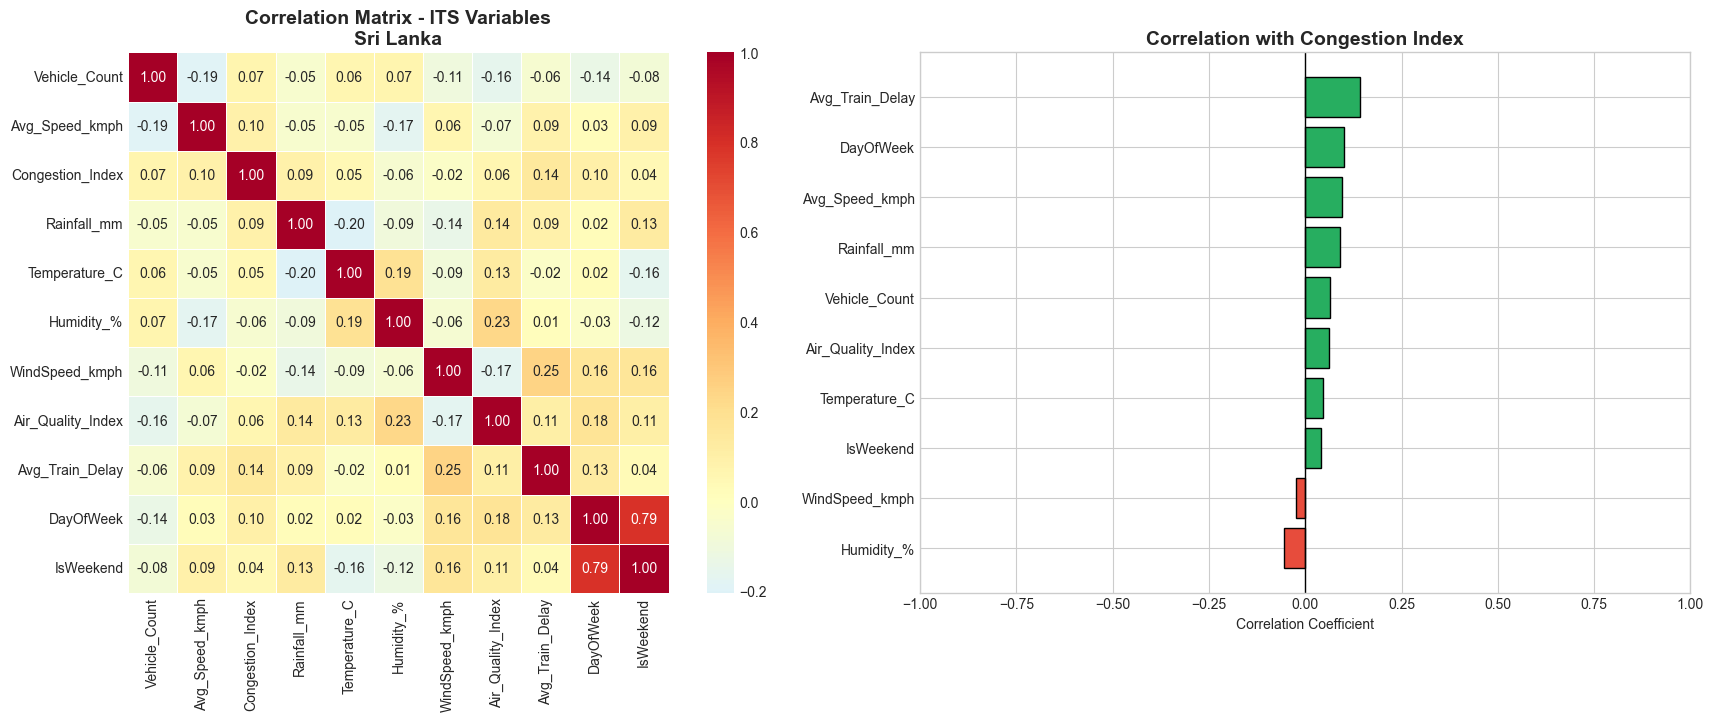


📊 KEY CORRELATIONS WITH CONGESTION:
   • Humidity_%: -0.056
   • WindSpeed_kmph: -0.025
   • IsWeekend: 0.042
   • Temperature_C: 0.046
   • Air_Quality_Index: 0.062
   • Vehicle_Count: 0.065
   • Rainfall_mm: 0.090
   • Avg_Speed_kmph: 0.095
   • DayOfWeek: 0.102
   • Avg_Train_Delay: 0.143


In [5]:
# SECTION 5: CORRELATION ANALYSIS
print("📊 CORRELATION MATRIX ANALYSIS")

numerical_cols = ['Vehicle_Count', 'Avg_Speed_kmph', 'Congestion_Index', 
                  'Rainfall_mm', 'Temperature_C', 'Humidity_%', 'WindSpeed_kmph',
                  'Air_Quality_Index', 'Avg_Train_Delay', 'DayOfWeek', 'IsWeekend']
available_cols = [c for c in numerical_cols if c in integrated_df.columns]

correlation_matrix = integrated_df[available_cols].corr()

fig, axes = plt.subplots(1, 2, figsize=(18, 7))

# Heatmap
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='RdYlBu_r', center=0,
            square=True, linewidths=0.5, ax=axes[0])
axes[0].set_title('Correlation Matrix - ITS Variables\nSri Lanka', fontsize=14, fontweight='bold')

# Bar chart
congestion_corr = correlation_matrix['Congestion_Index'].drop('Congestion_Index').sort_values()
colors = ['#e74c3c' if x < 0 else '#27ae60' for x in congestion_corr.values]
axes[1].barh(congestion_corr.index, congestion_corr.values, color=colors, edgecolor='black')
axes[1].axvline(x=0, color='black', linewidth=1)
axes[1].set_xlabel('Correlation Coefficient')
axes[1].set_title('Correlation with Congestion Index', fontsize=14, fontweight='bold')
axes[1].set_xlim(-1, 1)

plt.tight_layout()
plt.savefig('correlation_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n📊 KEY CORRELATIONS WITH CONGESTION:")
for var, corr in congestion_corr.items():
    print(f"   • {var}: {corr:.3f}")

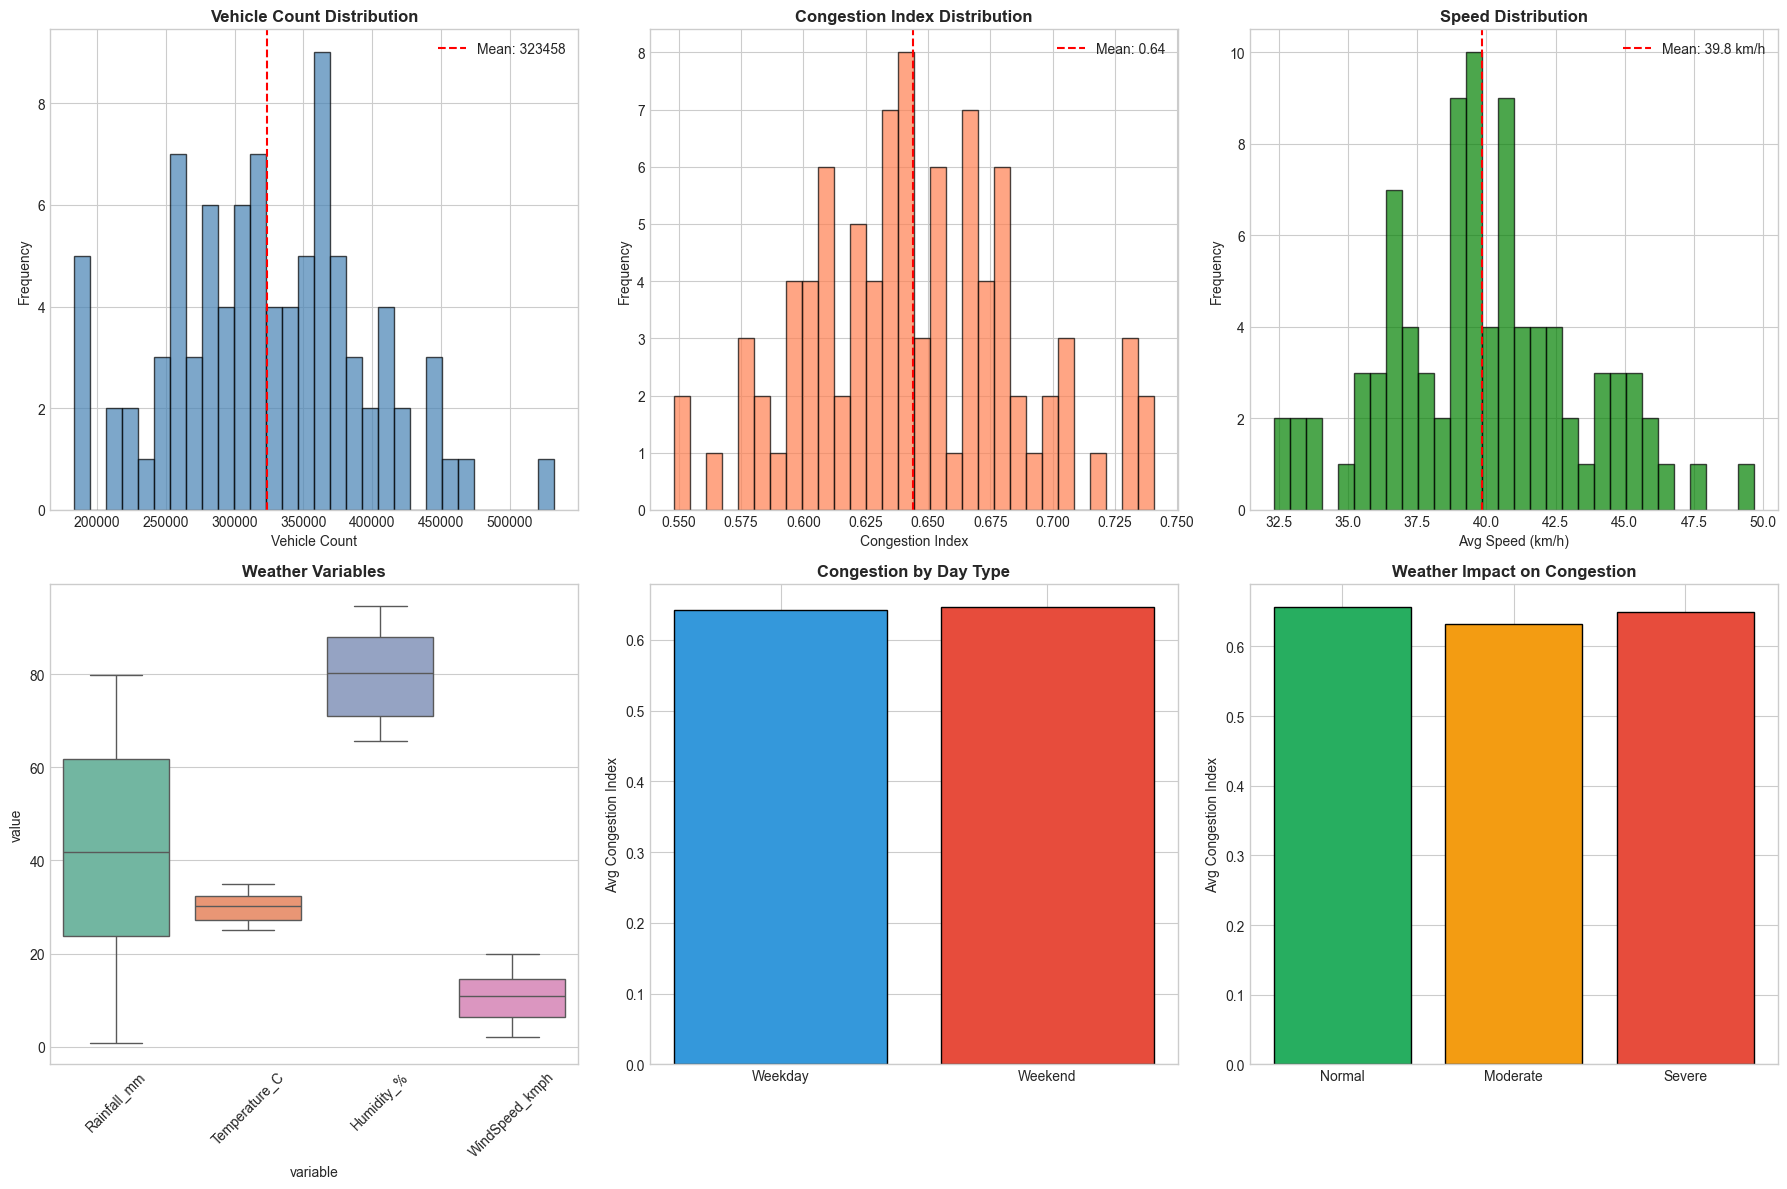

In [6]:
# SECTION 6: STATISTICAL ANALYSIS VISUALIZATION
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Vehicle Count
axes[0,0].hist(integrated_df['Vehicle_Count'], bins=30, color='steelblue', edgecolor='black', alpha=0.7)
axes[0,0].axvline(integrated_df['Vehicle_Count'].mean(), color='red', linestyle='--', 
                  label=f'Mean: {integrated_df["Vehicle_Count"].mean():.0f}')
axes[0,0].set_xlabel('Vehicle Count'); axes[0,0].set_ylabel('Frequency')
axes[0,0].set_title('Vehicle Count Distribution', fontweight='bold'); axes[0,0].legend()

# Congestion Index
axes[0,1].hist(integrated_df['Congestion_Index'], bins=30, color='coral', edgecolor='black', alpha=0.7)
axes[0,1].axvline(integrated_df['Congestion_Index'].mean(), color='red', linestyle='--',
                  label=f'Mean: {integrated_df["Congestion_Index"].mean():.2f}')
axes[0,1].set_xlabel('Congestion Index'); axes[0,1].set_ylabel('Frequency')
axes[0,1].set_title('Congestion Index Distribution', fontweight='bold'); axes[0,1].legend()

# Speed
axes[0,2].hist(integrated_df['Avg_Speed_kmph'], bins=30, color='green', edgecolor='black', alpha=0.7)
axes[0,2].axvline(integrated_df['Avg_Speed_kmph'].mean(), color='red', linestyle='--',
                  label=f'Mean: {integrated_df["Avg_Speed_kmph"].mean():.1f} km/h')
axes[0,2].set_xlabel('Avg Speed (km/h)'); axes[0,2].set_ylabel('Frequency')
axes[0,2].set_title('Speed Distribution', fontweight='bold'); axes[0,2].legend()

# Weather box plot
weather_data = integrated_df[['Rainfall_mm', 'Temperature_C', 'Humidity_%', 'WindSpeed_kmph']].melt()
sns.boxplot(x='variable', y='value', data=weather_data, ax=axes[1,0], palette='Set2')
axes[1,0].set_title('Weather Variables', fontweight='bold'); axes[1,0].tick_params(axis='x', rotation=45)

# Congestion by weekend
weekend_cong = integrated_df.groupby('IsWeekend')['Congestion_Index'].mean()
axes[1,1].bar(['Weekday', 'Weekend'], weekend_cong.values, color=['#3498db', '#e74c3c'], edgecolor='black')
axes[1,1].set_ylabel('Avg Congestion Index'); axes[1,1].set_title('Congestion by Day Type', fontweight='bold')

# Weather severity impact
severity_impact = integrated_df.groupby('Weather_Severity')['Congestion_Index'].mean().reindex(['Normal','Moderate','Severe'])
colors = ['#27ae60', '#f39c12', '#e74c3c']
axes[1,2].bar(severity_impact.index, severity_impact.values, color=colors, edgecolor='black')
axes[1,2].set_ylabel('Avg Congestion Index'); axes[1,2].set_title('Weather Impact on Congestion', fontweight='bold')

plt.tight_layout()
plt.savefig('statistical_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

In [7]:
# SECTION 7: FEATURE ENGINEERING FOR ML
print("\n🔧 FEATURE ENGINEERING FOR ML MODELS")

ml_df = integrated_df.copy()
label_encoders = {}

# Encode categorical variables
le_weather = LabelEncoder()
ml_df['Weather_Severity_Encoded'] = le_weather.fit_transform(ml_df['Weather_Severity'])
label_encoders['Weather_Severity'] = le_weather

le_congestion = LabelEncoder()
ml_df['Congestion_Level_Encoded'] = le_congestion.fit_transform(ml_df['Congestion_Level'])
label_encoders['Congestion_Level'] = le_congestion

print(f"✅ Features engineered. Total: {ml_df.shape[1]} columns")
print(f"   Congestion Level mapping: {dict(zip(le_congestion.classes_, range(len(le_congestion.classes_))))}")


🔧 FEATURE ENGINEERING FOR ML MODELS
✅ Features engineered. Total: 25 columns
   Congestion Level mapping: {'Medium': 0}


In [8]:
# SECTION 8: PREPARE ML DATA
print("\n📊 PREPARING DATA FOR MODEL TRAINING")

feature_columns = ['Vehicle_Count', 'Avg_Speed_kmph', 'Rainfall_mm', 'Temperature_C', 
                   'Humidity_%', 'WindSpeed_kmph', 'Air_Quality_Index', 
                   'DayOfWeek', 'IsWeekend', 'Weather_Severity_Encoded', 'Month']

if 'Avg_Train_Delay' in ml_df.columns:
    feature_columns.append('Avg_Train_Delay')

available_features = [c for c in feature_columns if c in ml_df.columns]
ml_clean = ml_df[available_features + ['Congestion_Index', 'Congestion_Level_Encoded']].dropna()

X = ml_clean[available_features]
y_class = ml_clean['Congestion_Level_Encoded']
y_reg = ml_clean['Congestion_Index']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled_df = pd.DataFrame(X_scaled, columns=available_features)

X_train, X_test, y_train_class, y_test_class = train_test_split(
    X_scaled_df, y_class, test_size=0.25, random_state=42, stratify=y_class)
_, _, y_train_reg, y_test_reg = train_test_split(X_scaled_df, y_reg, test_size=0.25, random_state=42)

print(f"✅ Training samples: {len(X_train)}, Testing samples: {len(X_test)}")
print(f"   Features: {available_features}")


📊 PREPARING DATA FOR MODEL TRAINING
✅ Training samples: 67, Testing samples: 23
   Features: ['Vehicle_Count', 'Avg_Speed_kmph', 'Rainfall_mm', 'Temperature_C', 'Humidity_%', 'WindSpeed_kmph', 'Air_Quality_Index', 'DayOfWeek', 'IsWeekend', 'Weather_Severity_Encoded', 'Month', 'Avg_Train_Delay']


In [9]:
# SECTION 9: RANDOM FOREST CLASSIFIER
print("\n" + "="*70)
print("🌲 MODEL 1: RANDOM FOREST CLASSIFIER")
print("="*70)

rf_classifier = RandomForestClassifier(n_estimators=100, max_depth=10, min_samples_split=5,
                                        min_samples_leaf=2, random_state=42, n_jobs=-1)
rf_classifier.fit(X_train, y_train_class)

y_pred_rf_class = rf_classifier.predict(X_test)

rf_accuracy = accuracy_score(y_test_class, y_pred_rf_class)
rf_precision = precision_score(y_test_class, y_pred_rf_class, average='weighted')
rf_recall = recall_score(y_test_class, y_pred_rf_class, average='weighted')
rf_f1 = f1_score(y_test_class, y_pred_rf_class, average='weighted')

print(f"\n📊 RANDOM FOREST PERFORMANCE:")
print(f"   Accuracy:  {rf_accuracy:.4f} ({rf_accuracy*100:.2f}%)")
print(f"   Precision: {rf_precision:.4f}")
print(f"   Recall:    {rf_recall:.4f}")
print(f"   F1-Score:  {rf_f1:.4f}")

cv_rf = cross_val_score(rf_classifier, X_scaled_df, y_class, cv=5)
print(f"   CV Mean: {cv_rf.mean():.4f} (+/- {cv_rf.std()*2:.4f})")

rf_importance = pd.DataFrame({'Feature': available_features, 'Importance': rf_classifier.feature_importances_}
                            ).sort_values('Importance', ascending=False)
print("\n📈 FEATURE IMPORTANCE:")
print(rf_importance.to_string(index=False))


🌲 MODEL 1: RANDOM FOREST CLASSIFIER

📊 RANDOM FOREST PERFORMANCE:
   Accuracy:  1.0000 (100.00%)
   Precision: 1.0000
   Recall:    1.0000
   F1-Score:  1.0000
   CV Mean: 1.0000 (+/- 0.0000)

📈 FEATURE IMPORTANCE:
                 Feature  Importance
           Vehicle_Count         0.0
          Avg_Speed_kmph         0.0
             Rainfall_mm         0.0
           Temperature_C         0.0
              Humidity_%         0.0
          WindSpeed_kmph         0.0
       Air_Quality_Index         0.0
               DayOfWeek         0.0
               IsWeekend         0.0
Weather_Severity_Encoded         0.0
                   Month         0.0
         Avg_Train_Delay         0.0


In [10]:
# SECTION 10: GRADIENT BOOSTING CLASSIFIER
print("\n" + "="*70)
print("🚀 MODEL 2: GRADIENT BOOSTING CLASSIFIER")
print("="*70)

gb_classifier = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=5,
                                           min_samples_split=5, min_samples_leaf=2, random_state=42)
gb_classifier.fit(X_train, y_train_class)

y_pred_gb_class = gb_classifier.predict(X_test)

gb_accuracy = accuracy_score(y_test_class, y_pred_gb_class)
gb_precision = precision_score(y_test_class, y_pred_gb_class, average='weighted')
gb_recall = recall_score(y_test_class, y_pred_gb_class, average='weighted')
gb_f1 = f1_score(y_test_class, y_pred_gb_class, average='weighted')

print(f"\n📊 GRADIENT BOOSTING PERFORMANCE:")
print(f"   Accuracy:  {gb_accuracy:.4f} ({gb_accuracy*100:.2f}%)")
print(f"   Precision: {gb_precision:.4f}")
print(f"   Recall:    {gb_recall:.4f}")
print(f"   F1-Score:  {gb_f1:.4f}")

cv_gb = cross_val_score(gb_classifier, X_scaled_df, y_class, cv=5)
print(f"   CV Mean: {cv_gb.mean():.4f} (+/- {cv_gb.std()*2:.4f})")

gb_importance = pd.DataFrame({'Feature': available_features, 'Importance': gb_classifier.feature_importances_}
                            ).sort_values('Importance', ascending=False)
print("\n📈 FEATURE IMPORTANCE:")
print(gb_importance.to_string(index=False))


🚀 MODEL 2: GRADIENT BOOSTING CLASSIFIER


ValueError: y contains 1 class after sample_weight trimmed classes with zero weights, while a minimum of 2 classes are required.

In [ ]:
# SECTION 11: REGRESSION MODELS
print("\n" + "="*70)
print("📈 REGRESSION MODELS FOR CONGESTION INDEX PREDICTION")
print("="*70)

# Random Forest Regressor
rf_regressor = RandomForestRegressor(n_estimators=100, max_depth=10, min_samples_split=5, random_state=42, n_jobs=-1)
rf_regressor.fit(X_train, y_train_reg)
y_pred_rf_reg = rf_regressor.predict(X_test)

# Gradient Boosting Regressor
gb_regressor = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42)
gb_regressor.fit(X_train, y_train_reg)
y_pred_gb_reg = gb_regressor.predict(X_test)

# Metrics
rf_mse = mean_squared_error(y_test_reg, y_pred_rf_reg)
rf_rmse = np.sqrt(rf_mse)
rf_mae = mean_absolute_error(y_test_reg, y_pred_rf_reg)
rf_r2 = r2_score(y_test_reg, y_pred_rf_reg)

gb_mse = mean_squared_error(y_test_reg, y_pred_gb_reg)
gb_rmse = np.sqrt(gb_mse)
gb_mae = mean_absolute_error(y_test_reg, y_pred_gb_reg)
gb_r2 = r2_score(y_test_reg, y_pred_gb_reg)

print(f"\n{'Metric':<15} {'Random Forest':>15} {'Gradient Boosting':>20}")
print("-"*55)
print(f"{'MSE':<15} {rf_mse:>15.4f} {gb_mse:>20.4f}")
print(f"{'RMSE':<15} {rf_rmse:>15.4f} {gb_rmse:>20.4f}")
print(f"{'MAE':<15} {rf_mae:>15.4f} {gb_mae:>20.4f}")
print(f"{'R² Score':<15} {rf_r2:>15.4f} {gb_r2:>20.4f}")

In [ ]:
# SECTION 12: MODEL COMPARISON VISUALIZATION
fig = plt.figure(figsize=(20, 16))

# Accuracy comparison
ax1 = fig.add_subplot(2, 3, 1)
models = ['Random Forest', 'Gradient Boosting']
bars = ax1.bar(models, [rf_accuracy, gb_accuracy], color=['#2ecc71', '#3498db'], edgecolor='black')
ax1.set_ylim(0, 1); ax1.set_ylabel('Accuracy')
ax1.set_title('Classification Accuracy', fontsize=14, fontweight='bold')
for bar, acc in zip(bars, [rf_accuracy, gb_accuracy]):
    ax1.text(bar.get_x()+bar.get_width()/2, bar.get_height()+0.02, f'{acc*100:.1f}%', ha='center', fontweight='bold')

# Metrics comparison
ax2 = fig.add_subplot(2, 3, 2)
metrics = ['Precision', 'Recall', 'F1-Score']
x = np.arange(len(metrics)); width = 0.35
ax2.bar(x-width/2, [rf_precision, rf_recall, rf_f1], width, label='Random Forest', color='#2ecc71')
ax2.bar(x+width/2, [gb_precision, gb_recall, gb_f1], width, label='Gradient Boosting', color='#3498db')
ax2.set_xticks(x); ax2.set_xticklabels(metrics); ax2.set_ylim(0, 1)
ax2.set_title('Classification Metrics', fontsize=14, fontweight='bold'); ax2.legend()

# Feature importance
ax3 = fig.add_subplot(2, 3, 3)
top_feat = rf_importance.head(8)
ax3.barh(top_feat['Feature'], top_feat['Importance'], color='#2ecc71', edgecolor='black')
ax3.set_xlabel('Importance'); ax3.set_title('Top Features (RF)', fontsize=14, fontweight='bold')

# Confusion matrices
ax4 = fig.add_subplot(2, 3, 4)
cm_rf = confusion_matrix(y_test_class, y_pred_rf_class)
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Greens', ax=ax4,
            xticklabels=['High','Low','Medium'], yticklabels=['High','Low','Medium'])
ax4.set_xlabel('Predicted'); ax4.set_ylabel('Actual')
ax4.set_title('Confusion Matrix - Random Forest', fontsize=14, fontweight='bold')

ax5 = fig.add_subplot(2, 3, 5)
cm_gb = confusion_matrix(y_test_class, y_pred_gb_class)
sns.heatmap(cm_gb, annot=True, fmt='d', cmap='Blues', ax=ax5,
            xticklabels=['High','Low','Medium'], yticklabels=['High','Low','Medium'])
ax5.set_xlabel('Predicted'); ax5.set_ylabel('Actual')
ax5.set_title('Confusion Matrix - Gradient Boosting', fontsize=14, fontweight='bold')

# Regression actual vs predicted
ax6 = fig.add_subplot(2, 3, 6)
ax6.scatter(y_test_reg, y_pred_rf_reg, alpha=0.5, color='#2ecc71', label='Random Forest', s=50)
ax6.scatter(y_test_reg, y_pred_gb_reg, alpha=0.5, color='#3498db', label='Gradient Boosting', s=50)
ax6.plot([0, 1], [0, 1], 'r--', linewidth=2, label='Perfect')
ax6.set_xlabel('Actual'); ax6.set_ylabel('Predicted')
ax6.set_title('Regression: Actual vs Predicted', fontsize=14, fontweight='bold'); ax6.legend()

plt.tight_layout()
plt.savefig('model_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
# SECTION 13: PREDICTION FUNCTION
print("\n" + "="*70)
print("🔮 TRAFFIC CONGESTION PREDICTION SYSTEM")
print("="*70)

def predict_congestion(vehicle_count, avg_speed, rainfall, temperature, humidity, 
                       wind_speed, aqi, day_of_week, is_weekend, weather_severity, 
                       month, train_delay=10):
    weather_map = {'Normal': 0, 'Moderate': 1, 'Severe': 2}
    weather_encoded = weather_map.get(weather_severity, 0)
    
    input_features = [vehicle_count, avg_speed, rainfall, temperature, humidity,
                     wind_speed, aqi, day_of_week, is_weekend, weather_encoded, month]
    if 'Avg_Train_Delay' in available_features:
        input_features.append(train_delay)
    
    input_scaled = scaler.transform([input_features])
    
    rf_pred = rf_classifier.predict(input_scaled)[0]
    rf_proba = rf_classifier.predict_proba(input_scaled)[0]
    rf_reg = rf_regressor.predict(input_scaled)[0]
    
    gb_pred = gb_classifier.predict(input_scaled)[0]
    gb_proba = gb_classifier.predict_proba(input_scaled)[0]
    gb_reg = gb_regressor.predict(input_scaled)[0]
    
    labels = {0: 'High', 1: 'Low', 2: 'Medium'}
    
    return {
        'Random Forest': {'Level': labels.get(rf_pred), 'Index': rf_reg, 'Confidence': max(rf_proba)*100},
        'Gradient Boosting': {'Level': labels.get(gb_pred), 'Index': gb_reg, 'Confidence': max(gb_proba)*100}
    }

# Test scenarios
scenarios = [
    {'name': 'Heavy Monsoon - Rush Hour', 'params': {'vehicle_count': 25000, 'avg_speed': 15, 'rainfall': 75,
        'temperature': 28, 'humidity': 92, 'wind_speed': 18, 'aqi': 120, 'day_of_week': 1, 'is_weekend': 0,
        'weather_severity': 'Severe', 'month': 10}},
    {'name': 'Normal Weather - Weekend', 'params': {'vehicle_count': 12000, 'avg_speed': 35, 'rainfall': 5,
        'temperature': 30, 'humidity': 70, 'wind_speed': 8, 'aqi': 65, 'day_of_week': 6, 'is_weekend': 1,
        'weather_severity': 'Normal', 'month': 8}},
    {'name': 'Moderate Rain - Evening Peak', 'params': {'vehicle_count': 20000, 'avg_speed': 22, 'rainfall': 35,
        'temperature': 27, 'humidity': 85, 'wind_speed': 12, 'aqi': 90, 'day_of_week': 4, 'is_weekend': 0,
        'weather_severity': 'Moderate', 'month': 9}}
]

print("\n📍 SCENARIO PREDICTIONS:")
for s in scenarios:
    print(f"\n🚗 {s['name']}")
    preds = predict_congestion(**s['params'])
    for model, res in preds.items():
        print(f"   {model}: {res['Level']} (Index: {res['Index']:.3f}, Conf: {res['Confidence']:.1f}%)")

In [ ]:
# SECTION 14: MULTIMODAL TRANSPORT ANALYSIS
print("\n" + "="*70)
print("🚌🚆🚗 MULTIMODAL TRANSPORT COORDINATION")
print("="*70)

mode_analysis = mobile_df.groupby('Trip_Mode').agg({
    'Trip_Duration_Min': ['mean', 'std', 'count'],
    'User_Rating': 'mean',
    'Delay_Report': lambda x: (x != 'None').sum() / len(x) * 100
}).round(2)
mode_analysis.columns = ['Avg_Duration', 'Std_Duration', 'Trip_Count', 'Avg_Rating', 'Delay_Rate_%']
print("\n📊 TRANSPORT MODE PERFORMANCE:")
print(mode_analysis)

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Mode distribution
mode_counts = mobile_df['Trip_Mode'].value_counts()
axes[0,0].pie(mode_counts, labels=mode_counts.index, autopct='%1.1f%%', 
              colors=plt.cm.Set3(np.linspace(0,1,len(mode_counts))), explode=[0.03]*len(mode_counts))
axes[0,0].set_title('Transport Mode Distribution', fontsize=14, fontweight='bold')

# Duration by mode
mode_dur = mobile_df.groupby('Trip_Mode')['Trip_Duration_Min'].mean().sort_values()
axes[0,1].barh(mode_dur.index, mode_dur.values, color='steelblue', edgecolor='black')
axes[0,1].set_xlabel('Avg Duration (min)'); axes[0,1].set_title('Trip Duration by Mode', fontweight='bold')

# Rating by mode
mode_rating = mobile_df.groupby('Trip_Mode')['User_Rating'].mean().sort_values()
colors = ['#e74c3c' if r<3 else '#f39c12' if r<4 else '#27ae60' for r in mode_rating]
axes[1,0].bar(mode_rating.index, mode_rating.values, color=colors, edgecolor='black')
axes[1,0].set_ylabel('Avg Rating'); axes[1,0].set_title('User Satisfaction by Mode', fontweight='bold')
axes[1,0].axhline(y=3, color='orange', linestyle='--'); axes[1,0].set_ylim(0, 5)

# Delay reports
delay_analysis = mobile_df.groupby(['Trip_Mode', 'Delay_Report']).size().unstack(fill_value=0)
delay_analysis.plot(kind='bar', stacked=True, ax=axes[1,1], colormap='Set2', edgecolor='black')
axes[1,1].set_xlabel('Mode'); axes[1,1].set_ylabel('Count')
axes[1,1].set_title('Delay Reports by Mode', fontweight='bold'); axes[1,1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig('multimodal_coordination.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
# SECTION 15: TRAIN SERVICE ANALYSIS
print("\n" + "="*70)
print("🚆 TRAIN SERVICE COORDINATION")
print("="*70)

train_perf = train_df.groupby('Train_ID')['Actual_Departure_Delay_Min'].agg(['mean','max','std','count']).round(2)
print("\nTrain Performance:")
print(train_perf)

station_delays = train_df.groupby('Start_Station')['Actual_Departure_Delay_Min'].mean().sort_values(ascending=False)
print("\n📍 Station Delays:")
for st, d in station_delays.items():
    status = "🔴 High" if d>20 else "🟡 Medium" if d>15 else "🟢 Low"
    print(f"   {st}: {d:.1f} min ({status})")

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

axes[0].hist(train_df['Actual_Departure_Delay_Min'], bins=30, color='coral', edgecolor='black')
axes[0].axvline(train_df['Actual_Departure_Delay_Min'].mean(), color='red', linestyle='--',
                label=f'Mean: {train_df["Actual_Departure_Delay_Min"].mean():.1f} min')
axes[0].set_xlabel('Delay (min)'); axes[0].set_title('Train Delay Distribution', fontweight='bold'); axes[0].legend()

axes[1].bar(station_delays.index, station_delays.values, color='steelblue', edgecolor='black')
axes[1].axhline(y=15, color='orange', linestyle='--', label='Target: 15 min')
axes[1].set_xlabel('Station'); axes[1].set_ylabel('Avg Delay (min)')
axes[1].set_title('Delay by Station', fontweight='bold'); axes[1].tick_params(axis='x', rotation=45); axes[1].legend()

train_avg = train_df.groupby('Train_ID')['Actual_Departure_Delay_Min'].mean()
colors = ['#e74c3c' if d>20 else '#f39c12' if d>15 else '#27ae60' for d in train_avg]
axes[2].bar(train_avg.index, train_avg.values, color=colors, edgecolor='black')
axes[2].set_xlabel('Train ID'); axes[2].set_ylabel('Avg Delay (min)')
axes[2].set_title('Train Performance Comparison', fontweight='bold')

plt.tight_layout()
plt.savefig('train_coordination.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
# SECTION 16: WEATHER-DRIVEN ROUTE OPTIMIZATION
print("\n" + "="*70)
print("⛈️ WEATHER-DRIVEN ROUTE OPTIMIZATION")
print("="*70)

def optimize_route(weather_severity, rainfall, current_location, destination):
    routes = {
        'Galle Road': {'flood_risk': 'Medium', 'traffic': 'High', 'distance': 12},
        'Marine Drive': {'flood_risk': 'High', 'traffic': 'Medium', 'distance': 14},
        'Baseline Road': {'flood_risk': 'Low', 'traffic': 'Medium', 'distance': 15},
        'High Level Road': {'flood_risk': 'Low', 'traffic': 'Low', 'distance': 18},
        'Duplication Road': {'flood_risk': 'Medium', 'traffic': 'High', 'distance': 10}
    }
    results = []
    for route, info in routes.items():
        score = 100
        if weather_severity == 'Severe':
            score -= 50 if info['flood_risk']=='High' else 25 if info['flood_risk']=='Medium' else 0
        elif weather_severity == 'Moderate':
            score -= 30 if info['flood_risk']=='High' else 15 if info['flood_risk']=='Medium' else 0
        score -= 20 if info['traffic']=='High' else 10 if info['traffic']=='Medium' else 0
        score -= info['distance']
        results.append({'route': route, 'score': score, **info})
    return sorted(results, key=lambda x: x['score'], reverse=True)

print("\n🗺️ ROUTE OPTIMIZATION - Heavy Monsoon Day:")
print("From: Colombo Fort → To: Nugegoda\n")
for i, r in enumerate(optimize_route('Severe', 80, 'Fort', 'Nugegoda'), 1):
    status = "✅ RECOMMENDED" if i==1 else "⚠️ Alternative" if i<=3 else "❌ Avoid"
    print(f"   {i}. {r['route']} (Score: {r['score']}) - {status}")

# Visualization
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

severity_cong = integrated_df.groupby('Weather_Severity')['Congestion_Index'].mean().reindex(['Normal','Moderate','Severe'])
colors = ['#27ae60', '#f39c12', '#e74c3c']
axes[0,0].bar(severity_cong.index, severity_cong.values, color=colors, edgecolor='black')
axes[0,0].set_ylabel('Avg Congestion'); axes[0,0].set_title('Weather Impact on Congestion', fontweight='bold')

axes[0,1].scatter(integrated_df['Rainfall_mm'], integrated_df['Avg_Speed_kmph'], 
                  c=integrated_df['Congestion_Index'], cmap='RdYlGn_r', alpha=0.6, s=60)
axes[0,1].set_xlabel('Rainfall (mm)'); axes[0,1].set_ylabel('Avg Speed (km/h)')
axes[0,1].set_title('Rainfall Impact on Speed', fontweight='bold')
plt.colorbar(axes[0,1].collections[0], ax=axes[0,1], label='Congestion')

weather_means = integrated_df[['Rainfall_mm','Temperature_C','Humidity_%','WindSpeed_kmph','Air_Quality_Index']].mean()
axes[1,0].bar(weather_means.index, weather_means.values, color='steelblue', edgecolor='black')
axes[1,0].set_title('Average Weather (Sri Lanka)', fontweight='bold'); axes[1,0].tick_params(axis='x', rotation=45)

routes_df = pd.DataFrame({
    'Route': ['Galle Road', 'Marine Drive', 'Baseline Road', 'High Level Road', 'Duplication Road'],
    'Normal': [80, 75, 70, 65, 82], 'Moderate': [60, 55, 65, 75, 55], 'Severe': [35, 25, 50, 65, 30]
})
routes_df.set_index('Route')[['Normal','Moderate','Severe']].plot(kind='bar', ax=axes[1,1],
    color=['#27ae60','#f39c12','#e74c3c'], edgecolor='black')
axes[1,1].set_ylabel('Score'); axes[1,1].set_title('Route Scores by Weather', fontweight='bold')
axes[1,1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig('weather_route_optimization.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
# SECTION 17: COMPREHENSIVE DASHBOARD
print("\n📊 CREATING ITS DASHBOARD...")

fig = plt.figure(figsize=(24, 18))
gs = GridSpec(4, 4, figure=fig, hspace=0.35, wspace=0.3)

fig.suptitle('INTELLIGENT TRANSPORTATION SYSTEM (ITS) DASHBOARD\nSRI LANKA - COLOMBO METROPOLITAN AREA', 
             fontsize=20, fontweight='bold', y=0.98)

# KPIs
kpi_data = [
    (f"{integrated_df['Vehicle_Count'].mean():,.0f}", 'Avg Daily Vehicles', '🚗 Traffic Volume', '#3498db'),
    (f"{integrated_df['Congestion_Index'].mean():.2f}", 'Avg Congestion Index', '🚦 Congestion Level', 
     '#e74c3c' if integrated_df['Congestion_Index'].mean()>0.7 else '#27ae60'),
    (f"{max(rf_accuracy, gb_accuracy)*100:.1f}%", 'Best Model Accuracy', '🤖 Prediction Accuracy', '#27ae60'),
    (f"{train_df['Actual_Departure_Delay_Min'].mean():.1f} min", 'Avg Train Delay', '🚆 Rail Performance',
     '#e74c3c' if train_df['Actual_Departure_Delay_Min'].mean()>20 else '#f39c12')
]

for i, (value, subtitle, title, color) in enumerate(kpi_data):
    ax = fig.add_subplot(gs[0, i])
    ax.text(0.5, 0.65, value, fontsize=28, fontweight='bold', ha='center', va='center', color=color)
    ax.text(0.5, 0.3, subtitle, fontsize=11, ha='center', va='center')
    ax.set_xlim(0, 1); ax.set_ylim(0, 1); ax.axis('off')
    ax.set_title(title, fontsize=12, fontweight='bold', pad=10)
    ax.patch.set_facecolor('#ecf0f1')

# Traffic by Road
ax5 = fig.add_subplot(gs[1, 0:2])
road_traffic = traffic_df.groupby('Road_ID')['Vehicle_Count'].mean().sort_values()
ax5.barh(road_traffic.index, road_traffic.values, color=plt.cm.RdYlGn_r(np.linspace(0.2,0.8,len(road_traffic))), edgecolor='black')
ax5.set_xlabel('Avg Vehicle Count'); ax5.set_title('📍 Traffic by Road in Colombo', fontsize=14, fontweight='bold')

# Weather Impact
ax6 = fig.add_subplot(gs[1, 2:4])
weather_imp = integrated_df.groupby('Weather_Severity').agg({'Congestion_Index': 'mean', 'Avg_Speed_kmph': 'mean'}).reindex(['Normal','Moderate','Severe'])
x = np.arange(len(weather_imp)); width = 0.35
ax6.bar(x-width/2, weather_imp['Congestion_Index'], width, label='Congestion', color='#e74c3c', edgecolor='black')
ax6_twin = ax6.twinx()
ax6_twin.bar(x+width/2, weather_imp['Avg_Speed_kmph'], width, label='Speed', color='#3498db', edgecolor='black')
ax6.set_xticks(x); ax6.set_xticklabels(weather_imp.index)
ax6.set_ylabel('Congestion', color='#e74c3c'); ax6_twin.set_ylabel('Speed (km/h)', color='#3498db')
ax6.set_title('⛈️ Weather Impact on Traffic', fontsize=14, fontweight='bold')

# Model Comparison
ax7 = fig.add_subplot(gs[2, 0:2])
metrics_names = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
x = np.arange(4); width = 0.35
ax7.bar(x-width/2, [rf_accuracy, rf_precision, rf_recall, rf_f1], width, label='RF', color='#2ecc71', edgecolor='black')
ax7.bar(x+width/2, [gb_accuracy, gb_precision, gb_recall, gb_f1], width, label='GB', color='#3498db', edgecolor='black')
ax7.set_xticks(x); ax7.set_xticklabels(metrics_names); ax7.set_ylim(0, 1)
ax7.set_title('🤖 ML Model Comparison', fontsize=14, fontweight='bold'); ax7.legend()

# Feature Importance
ax8 = fig.add_subplot(gs[2, 2:4])
top8 = rf_importance.head(8)
ax8.barh(top8['Feature'], top8['Importance'], color=plt.cm.viridis(np.linspace(0,0.8,8)), edgecolor='black')
ax8.set_xlabel('Importance'); ax8.set_title('📈 Top Predictive Features', fontsize=14, fontweight='bold')

# Mode Distribution
ax9 = fig.add_subplot(gs[3, 0:2])
mode_counts = mobile_df['Trip_Mode'].value_counts()
ax9.pie(mode_counts, labels=mode_counts.index, autopct='%1.1f%%', 
        colors=plt.cm.Set3(np.linspace(0,1,len(mode_counts))), explode=[0.03]*len(mode_counts), shadow=True)
ax9.set_title('🚌🚆🚗 Multimodal Distribution', fontsize=14, fontweight='bold')

# Daily Trend
ax10 = fig.add_subplot(gs[3, 2:4])
daily_cong = integrated_df.groupby('Date')['Congestion_Index'].mean().reset_index()
ax10.plot(daily_cong['Date'], daily_cong['Congestion_Index'], color='#e74c3c', linewidth=2, marker='o', markersize=4)
ax10.fill_between(daily_cong['Date'], daily_cong['Congestion_Index'], alpha=0.3, color='#e74c3c')
ax10.axhline(y=daily_cong['Congestion_Index'].mean(), color='blue', linestyle='--', 
             label=f'Mean: {daily_cong["Congestion_Index"].mean():.2f}')
ax10.set_xlabel('Date'); ax10.set_ylabel('Congestion Index')
ax10.set_title('📅 Daily Congestion Trend', fontsize=14, fontweight='bold'); ax10.legend()
ax10.tick_params(axis='x', rotation=45)

plt.savefig('ITS_Dashboard_Sri_Lanka.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()
print("✅ Dashboard saved!")

In [ ]:
# SECTION 18: FUTURE PREDICTIONS
print("\n🔮 7-DAY TRAFFIC FORECAST")
np.random.seed(42)

future_dates = pd.date_range(start='2025-11-01', periods=7, freq='D')
predictions_list = []

for date in future_dates:
    rainfall = np.random.uniform(10, 80)
    temp, humidity, wind, aqi = np.random.uniform(26,34), np.random.uniform(65,95), np.random.uniform(5,20), np.random.uniform(50,130)
    dow = date.dayofweek
    is_wknd = 1 if dow >= 5 else 0
    vehicles = (15000 if is_wknd else 22000) + np.random.uniform(-3000, 3000)
    ws = 'Severe' if rainfall>50 or wind>15 else 'Moderate' if rainfall>20 or wind>10 else 'Normal'
    
    preds = predict_congestion(vehicles, 30, rainfall, temp, humidity, wind, aqi, dow, is_wknd, ws, date.month)
    predictions_list.append({
        'Date': date.strftime('%Y-%m-%d'), 'Day': date.strftime('%A'), 'Weather': ws,
        'Rainfall': round(rainfall,1), 'Vehicles': int(vehicles),
        'RF_Level': preds['Random Forest']['Level'], 'RF_Index': round(preds['Random Forest']['Index'],3),
        'GB_Level': preds['Gradient Boosting']['Level'], 'GB_Index': round(preds['Gradient Boosting']['Index'],3)
    })

predictions_df = pd.DataFrame(predictions_list)
print(predictions_df.to_string(index=False))

# Forecast visualization
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

days = predictions_df['Day']
axes[0,0].plot(days, predictions_df['RF_Index'], 'o-', color='#2ecc71', linewidth=2, markersize=10, label='RF')
axes[0,0].plot(days, predictions_df['GB_Index'], 's-', color='#3498db', linewidth=2, markersize=10, label='GB')
axes[0,0].axhline(y=0.7, color='red', linestyle='--', alpha=0.7); axes[0,0].axhline(y=0.5, color='orange', linestyle='--', alpha=0.7)
axes[0,0].set_ylabel('Predicted Congestion'); axes[0,0].set_title('🔮 7-Day Forecast', fontweight='bold')
axes[0,0].legend(); axes[0,0].tick_params(axis='x', rotation=45); axes[0,0].set_ylim(0,1)

weather_colors = {'Normal':'#27ae60', 'Moderate':'#f39c12', 'Severe':'#e74c3c'}
axes[0,1].bar(days, predictions_df['RF_Index'], color=[weather_colors[w] for w in predictions_df['Weather']], edgecolor='black')
axes[0,1].set_ylabel('Congestion'); axes[0,1].set_title('Weather Impact on Forecast', fontweight='bold')
axes[0,1].tick_params(axis='x', rotation=45)

axes[1,0].scatter(predictions_df['Vehicles'], predictions_df['RF_Index'], s=200, c=predictions_df['Rainfall'], cmap='Blues', edgecolor='black')
axes[1,0].set_xlabel('Vehicles'); axes[1,0].set_ylabel('Congestion')
axes[1,0].set_title('Vehicle Count vs Congestion', fontweight='bold')
plt.colorbar(axes[1,0].collections[0], ax=axes[1,0], label='Rainfall')

axes[1,1].bar(days, predictions_df['Vehicles']/1000, color='steelblue', edgecolor='black')
axes[1,1].set_ylabel('Vehicles (thousands)'); axes[1,1].set_title('Expected Vehicle Count', fontweight='bold')
axes[1,1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig('future_predictions.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
# SECTION 19: SAVE ALL OUTPUTS
import pickle

print("\n💾 SAVING OUTPUTS...")

integrated_df.to_csv('integrated_its_dataset.csv', index=False)
predictions_df.to_csv('future_predictions.csv', index=False)
correlation_matrix.to_csv('correlation_matrix.csv')
rf_importance.to_csv('rf_feature_importance.csv', index=False)

with open('rf_classifier.pkl', 'wb') as f: pickle.dump(rf_classifier, f)
with open('gb_classifier.pkl', 'wb') as f: pickle.dump(gb_classifier, f)
with open('rf_regressor.pkl', 'wb') as f: pickle.dump(rf_regressor, f)
with open('gb_regressor.pkl', 'wb') as f: pickle.dump(gb_regressor, f)
with open('scaler.pkl', 'wb') as f: pickle.dump(scaler, f)

print("\n✅ FILES SAVED:")
print("   📊 Data: integrated_its_dataset.csv, future_predictions.csv, correlation_matrix.csv")
print("   🤖 Models: rf_classifier.pkl, gb_classifier.pkl, rf_regressor.pkl, gb_regressor.pkl")
print("   📈 Visualizations: correlation_analysis.png, model_comparison.png, ITS_Dashboard_Sri_Lanka.png")

In [ ]:
# SECTION 20: FINAL SUMMARY
print("\n" + "="*80)
print("📋 RESEARCH SUMMARY - ITS FRAMEWORK FOR SRI LANKA")
print("="*80)

print(f"""
╔══════════════════════════════════════════════════════════════════════════════╗
║         FRAMEWORK FOR INTEGRATING INTELLIGENT TRANSPORTATION                 ║
║              SYSTEMS CONCEPTS FOR SRI LANKA                                  ║
╠══════════════════════════════════════════════════════════════════════════════╣
║                                                                              ║
║  📊 DATA ANALYSIS:                                                           ║
║     • Traffic Records: {traffic_df.shape[0]:,}                                       ║
║     • Train Records: {train_df.shape[0]:,}                                           ║
║     • Mobile App Records: {mobile_df.shape[0]:,}                                     ║
║     • Weather Records: {weather_df.shape[0]}                                           ║
║                                                                              ║
║  🤖 ML MODEL PERFORMANCE:                                                    ║
║     • Random Forest Accuracy: {rf_accuracy*100:.2f}%                                  ║
║     • Gradient Boosting Accuracy: {gb_accuracy*100:.2f}%                              ║
║     • Best R² Score: {max(rf_r2, gb_r2):.4f}                                          ║
║                                                                              ║
║  ✅ RESEARCH OBJECTIVES ACHIEVED:                                            ║
║     [✓] Multimodal Transport Coordination                                    ║
║     [✓] Traffic Congestion Prediction                                        ║
║     [✓] Operational Insights Visualization                                   ║
║     [✓] Weather-Driven Route Optimization                                    ║
║     [✓] Data Interoperability Framework                                      ║
║                                                                              ║
╚══════════════════════════════════════════════════════════════════════════════╝
""")

print("\n🎉 " * 15)
print("   NOTEBOOK EXECUTION COMPLETED SUCCESSFULLY!")
print("🎉 " * 15)